In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.cuda.is_available())

1.8.1+cu102
True


在GPU上训练只需要两步：
- 将模型转移到GPU；
- 将每个批次的训练数据转移到GPU；

## 导入数据集
torchvision内置了常见的数据集和模型

In [2]:
from torchvision import datasets, transforms

1. transforms.ToTensor(): 
    - 将数据转换为tensor;
    - 将数据进行归一化操作;
    - 会将图片数据中的channel维度放在第1维度
2. xjkasbkjx

In [3]:
transformation = transforms.Compose([transforms.ToTensor()])
# 数据集中transform是让你自己设定对于这个数据集要做的一些转换和变换操作的，上面定义的transformation就是定义一系列需要对这个数据集做的一些转换，将这些转换以列表的形式放在transforms.Compose中
train_dataset = datasets.MNIST(root="datasets/MNIST", train=True, 
                               transform=transformation, 
                               download=True)

  9%|▉         | 888832/9912422 [02:00<1:36:27, 1559.24it/s]

In [4]:
test_dataset = datasets.MNIST(root="datasets/MNIST", train=False, 
                              transform=transformation, 
                              download=True)

In [5]:
traindata_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testdata_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [6]:
traindata_loader

In [7]:
images, labels = next(iter(traindata_loader))

In [8]:
images.shape #pytorch中图片数据的形式为[batch, channel, height, width]

torch.Size([64, 1, 28, 28])

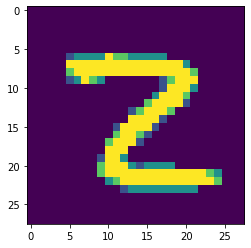

In [9]:
image = images[0]
img = np.squeeze(image.numpy())
plt.imshow(img)

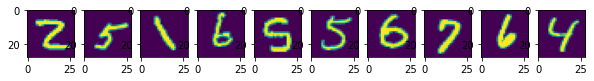

In [10]:
def image_show(img):
    img = np.squeeze(img.numpy())
    plt.imshow(img)

plt.figure(figsize=(10, 1))
for i, img in enumerate(images[:10]):
    plt.subplot(1, 10, i+1)
    image_show(img)

## 创建模型
- 单层创建：torch.nn.Linear()
- torch.nn.Sequential()
- 自定义类：继承自torch.nn.Module

In [11]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        # 继承父类中所有的属性
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, 
                                     out_channels=6,
                                     kernel_size=5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                     out_channels=16,
                                     kernel_size=5)                         
        self.linear_1 = torch.nn.Linear(in_features=16*4*4, out_features=256)
        self.linear_2 = torch.nn.Linear(in_features=256, out_features=10)
    def forward(self, input): # 覆盖重写父类中的该方法
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1) 
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [12]:
learning_rate = 0.01
epochs = 30

def get_model():
    model = Model()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    return model, optimizer

model, optimizer = get_model()
loss_func = torch.nn.CrossEntropyLoss()

# 将模型转移到GPU上进行训练
# 1. 将模型model转移到GPU上
# 2. 将每一批次的训练数据转移到GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device=device) 

## 创建损失函数

In [13]:
def fit(model, traindata_loader, testdata_loader, epoch):
    pred_corrected_num = 0
    total_num = 0
    training_batch_loss = 0
    for x, y in traindata_loader:
        x, y = x.to(device), y.to(device) # 将数据转移到GPU上
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            pred_corrected_num += (y_pred == y).sum().item()
            total_num += y.shape[0]
            training_batch_loss += loss.item()
    epoch_accuracy = pred_corrected_num / total_num
    epoch_loss = training_batch_loss / len(traindata_loader.dataset)
    #---------------------------------------------------------------
    test_pred_corrected_num = 0
    test_total_num = 0
    test_batch_loss = 0
    with torch.no_grad():
        for x, y in testdata_loader:
            x, y = x.to(device), y.to(device) # 将数据转移到GPU上
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_pred_corrected_num += (y_pred == y).sum().item()
            test_total_num += y.shape[0]
            test_batch_loss += loss.item()
    test_accuracy = test_pred_corrected_num / test_total_num
    test_loss = test_batch_loss / len(testdata_loader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
        "loss = ", round(epoch_loss, 3), 
        "accuracy = ", round(epoch_accuracy, 3),              
        "test_loss = ", round(test_loss, 3),
        "test_accuracy = ", round(test_accuracy, 3))
    return epoch_loss, epoch_accuracy, test_loss, test_accuracy

In [14]:
train_loss = []
train_accuracy = []
test_loss_ = []
test_accuracy_ = []

for epoch in range(epochs):
    epoch_loss, epoch_accuracy, test_loss, test_accuracy = fit(model, traindata_loader,
                                                               testdata_loader, epoch)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    test_loss_.append(test_loss)
    test_accuracy_.append(test_accuracy)

epoch =  0 loss =  0.004 accuracy =  0.927 test_loss =  0.0 test_accuracy =  0.978
epoch =  1 loss =  0.001 accuracy =  0.976 test_loss =  0.0 test_accuracy =  0.974
epoch =  2 loss =  0.001 accuracy =  0.979 test_loss =  0.0 test_accuracy =  0.983
epoch =  3 loss =  0.001 accuracy =  0.98 test_loss =  0.0 test_accuracy =  0.977
epoch =  4 loss =  0.001 accuracy =  0.983 test_loss =  0.0 test_accuracy =  0.98
epoch =  5 loss =  0.001 accuracy =  0.982 test_loss =  0.0 test_accuracy =  0.984
epoch =  6 loss =  0.001 accuracy =  0.983 test_loss =  0.0 test_accuracy =  0.983
epoch =  7 loss =  0.001 accuracy =  0.984 test_loss =  0.0 test_accuracy =  0.981
epoch =  8 loss =  0.001 accuracy =  0.985 test_loss =  0.0 test_accuracy =  0.982
epoch =  9 loss =  0.001 accuracy =  0.987 test_loss =  0.0 test_accuracy =  0.971
epoch =  10 loss =  0.001 accuracy =  0.984 test_loss =  0.0 test_accuracy =  0.976
epoch =  11 loss =  0.001 accuracy =  0.986 test_loss =  0.0 test_accuracy =  0.981
epoc

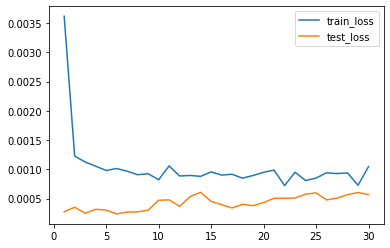

In [15]:
plt.plot(range(1, epochs+1), train_loss, label="train_loss")
plt.plot(range(1, epochs+1), test_loss_, label="test_loss")
plt.legend()

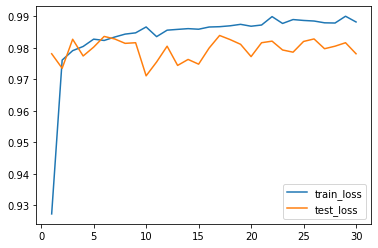

In [16]:
plt.plot(range(1, epochs+1), train_accuracy, label="train_loss")
plt.plot(range(1, epochs+1), test_accuracy_, label="test_loss")
plt.legend()